In [127]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

In [128]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
    for k, v in j['stats'].items():
        col[k] = v
    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    #col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    #col['digits_object'] = 1 - col['digits_entropy']
    #col['letters_object'] = 1 - col['letters_entropy']
    #col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    #col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

In [129]:
df_full['recons'].isna().sum()

77

## Fix stride. vary nb of layers

In [130]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,nb_layers,nb_params,noise,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9e80faae4fb4ae36b2766648824eac09,128.0,0.116791,12.550046,0.086,0.800376,0.191304,6.500855e+07,0.078,0.002076,4.151053,0.018,0.013,0.757,0.352276,0.141,5.123708,NaN,0.522073,0.082004,14.290085,0.848,0.810578,0.347885,1.427359e+08,0.501,0.002082,5.316375,1,6529.0,NaN,0.967,0.0003,mnist_deep,2.0,NaN
68adffea6c98fedf329644122d56fa36,128.0,0.039539,19.538910,0.577,0.911845,0.087772,6.482822e+07,0.517,0.002000,6.700230,0.090,0.080,0.568,0.248701,0.173,13.314023,NaN,0.788424,0.112240,57.670715,0.365,0.926126,0.116562,1.426116e+08,0.316,0.002006,14.033784,2,825985.0,NaN,1.000,0.4166,mnist_deep,2.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.031575,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002000,6.845440,0.108,0.096,0.482,0.246643,0.154,12.352144,NaN,0.765771,0.100727,52.514980,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,14.415942,3,1645441.0,NaN,1.000,0.1821,mnist_deep,2.0,NaN
63c1be88f742117d115d076216ac85d1,128.0,0.020904,10.919588,0.849,0.916866,0.055326,6.480193e+07,0.794,0.002000,7.269512,0.130,0.121,0.440,0.208254,0.196,10.687059,NaN,0.676443,0.095547,33.215351,0.124,0.778797,0.088160,1.426905e+08,0.113,0.002006,9.548794,4,2464897.0,NaN,1.000,0.1293,mnist_deep,2.0,NaN
581582abec259852f4a01f7e79ed97db,128.0,0.020118,7.382170,0.964,0.851105,0.056269,6.483472e+07,0.886,0.002008,6.220617,0.128,0.122,0.458,0.212822,0.178,8.264774,NaN,0.614825,0.109743,22.542377,0.024,0.767487,0.096898,1.427642e+08,0.021,0.002014,9.044111,5,3284353.0,NaN,0.996,0.0318,mnist_deep,2.0,NaN
8ecaf99d22cf4cb469912b9fae25aac2,128.0,0.008583,4.169066,0.998,0.630844,0.042352,6.493132e+07,0.967,0.005644,3.949130,0.098,0.093,0.331,0.196629,0.108,5.691341,NaN,0.426911,0.099368,8.652865,0.001,0.602850,0.086963,1.428706e+08,0.001,0.005650,5.471218,6,4103809.0,NaN,0.593,0.0097,mnist_deep,2.0,NaN


In [ ]:
show(df)

## Fix nb layers. Vary stride

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

In [ ]:
show(df)

# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [ ]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [146]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = df_full['recons'].fillna(0.0)

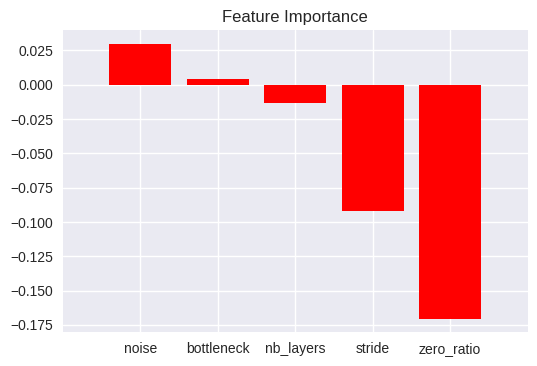

In [173]:
import scikitplot as pl
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
#reg = GradientBoostingRegressor(n_estimators=30, max_depth=20)
reg.fit(x, y)
reg.feature_importances_ = reg.coef_
pl.estimators.plot_feature_importances(reg, feature_names=x.columns)

In [174]:
pd.DataFrame({'delta': np.abs(reg.predict(x)-y), 'y': y})

,delta,y
job_id,,
cd9b3b770c1b54d09b957e5f9398b7a6,0.292583,0.0030
c1eb1e14d01fdf37906ee5b1c9535bd8,0.088909,0.1545
a167259933f54183c717cd4ed0529081,0.568360,0.8509
f316dedd30ebc5f51c4678f07979436c,0.394004,0.6635
ba180701c3c58a4de3f48662b850dc90,0.124548,0.3810
8c70ff3d0c22c47c450609b02ab56ee9,0.212065,0.0183
9e80faae4fb4ae36b2766648824eac09,0.202946,0.0003
581582abec259852f4a01f7e79ed97db,0.119271,0.0318
68adffea6c98fedf329644122d56fa36,0.226398,0.4166


In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

In [ ]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [131]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'recons'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,recons
digits_count,1,-0.897334,0.504346,0.410802,0.0418502,0.47685,-0.070926
letters_count,-0.897334,1,-0.420536,-0.322768,0.0374954,-0.395098,0.114456
digits_objectness,0.504346,-0.420536,1,0.921371,0.716197,0.956652,-0.0012833
letters_objectness,0.410802,-0.322768,0.921371,1,0.832285,0.957296,0.232424
digits_and_letters_objectness,0.0418502,0.0374954,0.716197,0.832285,1,0.74305,0.185253
emnist_objectness,0.47685,-0.395098,0.956652,0.957296,0.74305,1,0.144438
recons,-0.070926,0.114456,-0.0012833,0.232424,0.185253,0.144438,1


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


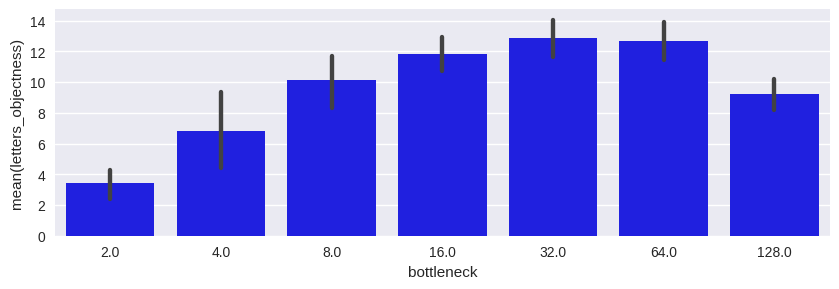

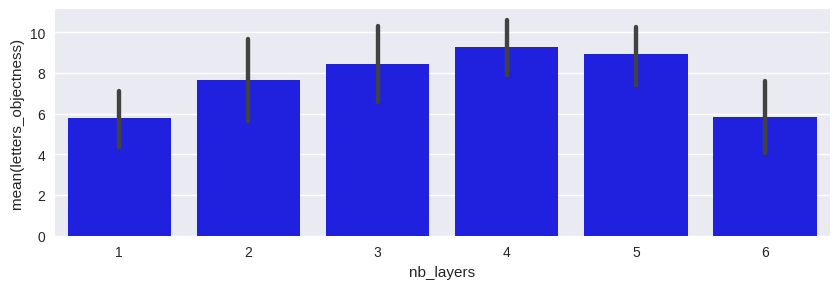

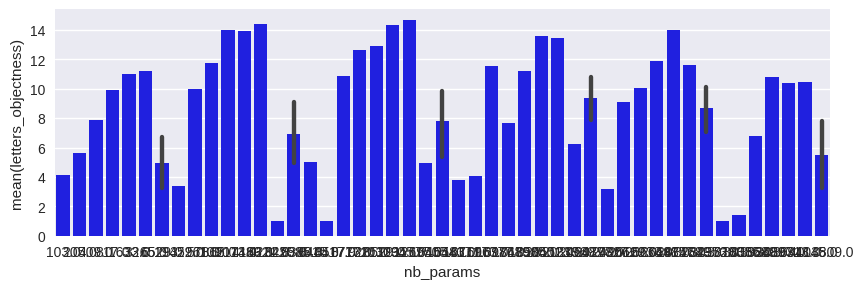

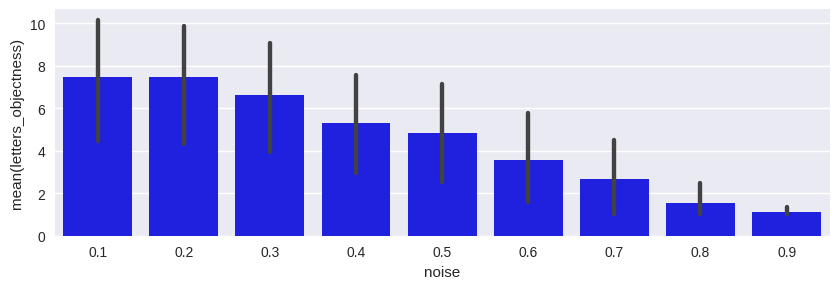

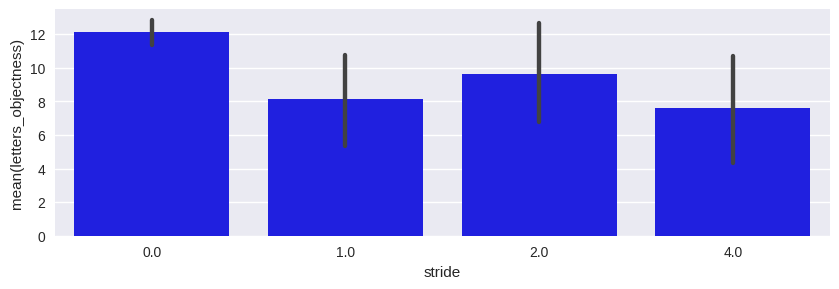

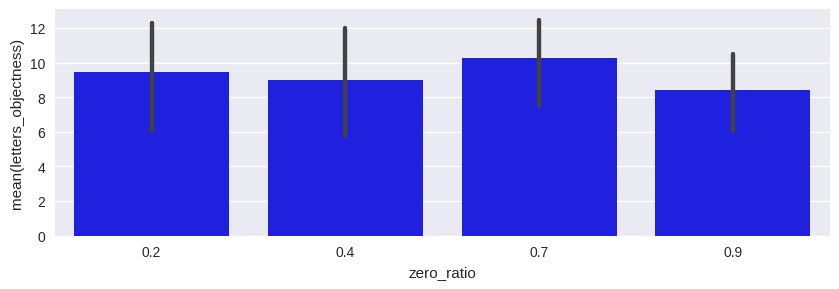

In [132]:
d = df_full
#d = df_full.fillna(-1)
#d = d[d['sampler']  == 'mnist_capacity']
ycols = ['letters_objectness']
xcols = ['bottleneck', 'nb_layers', 'nb_params', 'noise', 'stride', 'zero_ratio']
for xcol in xcols:
    for ycol in ycols:
        fig = plt.figure(figsize=(10, 3))
        sns.barplot(x=xcol, y=ycol, data=d, color='blue')
        plt.show()

In [137]:
d = df_full
#d = d[d['nb_layers']==6]
d = d.sort_values(by='recons', ascending=False)
d.iloc[0:10]
#show(d.iloc[0:20])

,bottleneck,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,nb_layers,nb_params,noise,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68d5ee04e4b8638c35f7024f07817250,128.0,0.055944,17.414164,0.254,0.791825,0.147050,6.492082e+07,0.221,0.002000,4.463392,0.034,0.032,0.713,0.302965,0.138,6.574965,NaN,0.640593,0.090156,27.442280,0.676,0.859386,0.144903,1.426590e+08,0.542,0.002006,10.579434,2,825985.0,NaN,1.000,0.9323,mnist_deep,0.0,NaN
fcce855f0ae6a9391c25846ba8f922fd,128.0,0.289658,4.532099,0.082,0.546001,0.317613,6.507256e+07,0.069,0.192666,2.338978,0.029,0.026,0.412,0.271371,0.079,2.681726,NaN,0.373804,0.175185,5.693460,0.876,0.611643,0.436177,1.428649e+08,0.344,0.192672,3.675390,2,825985.0,NaN,0.505,0.9185,mnist_deep_lifetime,NaN,0.2
a167259933f54183c717cd4ed0529081,128.0,0.041000,18.065023,0.589,0.870865,0.077320,6.481716e+07,0.537,0.002000,6.289638,0.098,0.089,0.579,0.234873,0.188,13.520828,NaN,0.794980,0.108532,60.633957,0.330,0.926827,0.109443,1.425949e+08,0.279,0.002006,14.407940,2,825985.0,NaN,1.000,0.8509,mnist_deep,1.0,NaN
9fac5b60f593b92c11133f9813f3c5a9,128.0,0.170560,10.294384,0.321,0.684025,0.218601,6.494705e+07,0.290,0.060322,3.376249,0.099,0.097,0.457,0.266032,0.108,7.324684,NaN,0.590792,0.149898,18.387068,0.644,0.751009,0.264205,1.427253e+08,0.354,0.060328,6.982135,2,825985.0,NaN,0.759,0.7324,mnist_deep_lifetime,NaN,0.4
5511413bb44248b61f32518f638a8d9e,128.0,0.043103,15.068205,0.712,0.912121,0.109552,6.482374e+07,0.621,0.002000,6.414445,0.031,0.029,0.694,0.310742,0.131,8.729666,NaN,0.646863,0.100108,26.331829,0.231,0.917145,0.121261,1.426300e+08,0.193,0.002006,13.536750,3,1645441.0,NaN,1.000,0.7190,mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,0.031410,14.714568,0.773,0.924139,0.083757,6.478472e+07,0.713,0.002000,6.948976,0.081,0.073,0.572,0.254680,0.178,12.290185,NaN,0.775435,0.104893,55.180447,0.172,0.926554,0.101766,1.426092e+08,0.153,0.002006,14.877086,3,1645441.0,NaN,1.000,0.6635,mnist_deep,1.0,NaN
1b5d05f8b98c924866c3d15937dea0a7,128.0,0.043250,21.097599,0.476,0.877976,0.102221,6.485625e+07,0.438,0.002056,6.064814,0.056,0.051,0.622,0.262607,0.196,10.986717,NaN,0.776695,0.108418,52.687130,0.484,0.903419,0.120399,1.426189e+08,0.394,0.002062,13.124297,2,825985.0,NaN,0.993,0.5622,mnist_deep_kchannel,NaN,0.7
6200e894f920a6659d48adcb799e1bee,128.0,0.110627,7.355932,0.131,0.722970,0.265471,6.500076e+07,0.115,0.042311,3.124804,0.019,0.016,0.762,0.283204,0.083,3.137175,NaN,0.389053,0.069677,7.466353,0.841,0.620513,0.169838,1.427632e+08,0.493,0.042317,5.077163,3,1645441.0,NaN,0.651,0.4946,mnist_deep_lifetime,NaN,0.2
cc68a4a318fc51e325ec4b74e1563812,128.0,0.039947,19.870729,0.550,0.928253,0.089378,6.480360e+07,0.503,0.002000,6.912533,0.067,0.060,0.500,0.281559,0.132,11.834738,NaN,0.769208,0.120771,49.336044,0.398,0.891979,0.101825,1.425943e+08,0.322,0.002006,13.323232,3,1645441.0,NaN,1.000,0.4765,mnist_deep_kchannel,NaN,0.7
